In [28]:
import importlib
import src.data_preparation
import src.network
importlib.reload(src.data_preparation)
importlib.reload(src.network)

from src.data_preparation import *
from src.network import *
import sys

from tqdm import tqdm

56457
153
369


<Figure size 640x480 with 0 Axes>

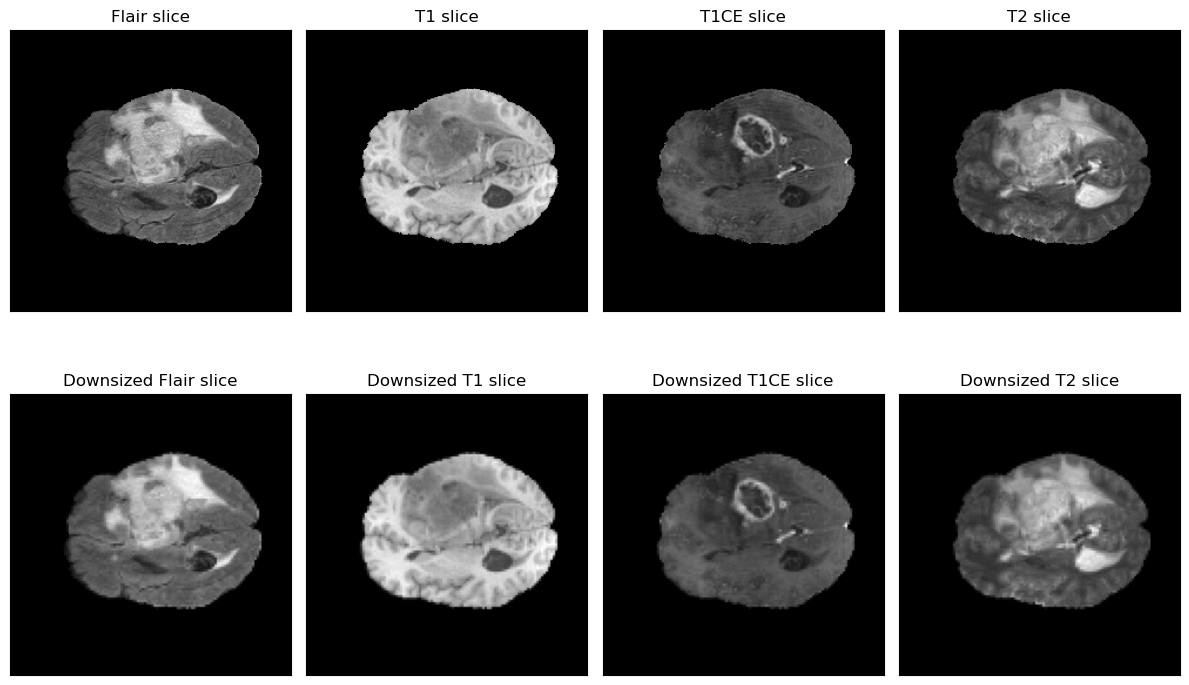

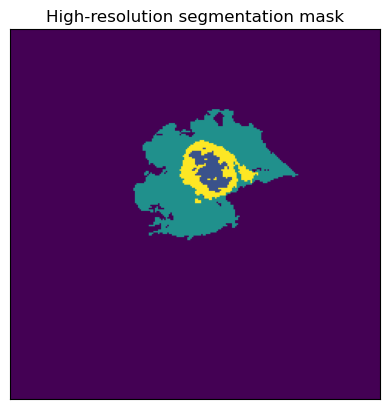

In [29]:
TRAIN_DATASET_PATH = '../BRATS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = BRATS_dataset(TRAIN_DATASET_PATH, device, num_slices = 3, downsamp_ratio = 2, downsamp_type = 'bilinear')
test_loader = DataLoader(test_dataset, batch_size=1)
iter_loader = iter(test_loader)

idx = 70

img_list, ds_img_list, mask = test_dataset[70]
    
img_labels = ["Flair", "T1", "T1CE", "T2"]

#Plot an example

plt.gray()
fig,ax = plt.subplots(2,4, figsize=(12,8))

for j in range(4):
    ax[0,j].imshow(img_list[j][1,:,:].squeeze().cpu().detach())
    ax[0,j].set_title(img_labels[j] + " slice")
    ax[1,j].imshow(ds_img_list[j][1,:,:].squeeze().cpu().detach())
    ax[1,j].set_title("Downsized " + img_labels[j] + " slice")
    

for ax in fig.get_axes():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='y', length=0)
    
fig.tight_layout()
fig.show()

plt.figure()
plt.imshow(mask.cpu().detach(), cmap = 'viridis')
plt.title("High-resolution segmentation mask")
plt.xticks([])
plt.yticks([])
plt.show()


In [30]:

num_classes = 5
model = VAE_UNET(3, test_dataset.input_dim, test_dataset.output_dim, num_classes)
model = model.to(device)

train_loader = DataLoader(test_dataset, batch_size=5)

learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion_seg = nn.CrossEntropyLoss()
criterion_SR = nn.MSELoss()


In [31]:
num_epochs = 10

for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    i = 0
    
    for img_list, ds_img_list, mask in train_bar:

        optimizer.zero_grad()
        output_seg, output_VAE = model(ds_img_list[0])
        loss = criterion_seg(output_seg, mask.long())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
  
        i += 1


Epoch 1/10 [Training]:  18%|█▊        | 1983/11292 [17:50<1:23:44,  1.85it/s, loss=0.905]


KeyboardInterrupt: 